##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [45]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# pool.close()

In [46]:
def Curve(x,a,b,c):
    return (a/(b+x)**c)

def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    return(Models)

def TTV_Split(iteration,Memory,X,y,params,X_fill,Save):
    params['seed'] = int(iteration%params['splits_per_mod']/params['splits_per_mod']*100)
    params['iteration'] = int(iteration/params['splits_per_mod'])
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=params['seed'])
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=params['seed'])
    return(Dense.Train_Steps(params,X_train,X_test,X_val,y_train,y_test,
        y_val,X_fill = X_fill,Memory=Memory,Save=Save),
        y_val)

def RunReps(Model,params,pool = None,FullReturn=False,Save=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    if params['T'] >0:
        RST.TimeShape(params['T'])
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MSE = []
    R2 =[]
    Y_fill = []
    Yval = []
    y_val= []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill,
                                                     Save=Save),range(params['K']))):
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1][0].reshape(-1,1))
            MSE.append(metrics.mean_squared_error(Yval,y_val))
            R2.append(metrics.r2_score(Yval,y_val))
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill,Save)
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MSE.append(metrics.mean_squared_error(y_val,Yval))
            R2.append(metrics.r2_score(y_val,Yval))
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0) 
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)
    return(MSE,R2,RST.Master['TempFill'])

In [48]:
FillVar = 'fco2'
FullModel = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg',
             'VPD','Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
FullModel = ['PPFD_Avg','AirTC_Avg','Sedge']
Runs,params = Dense.Params('Test',FillVar,MP=False)
print(params)

from ipywidgets import FloatProgress
from IPython.display import display

# Data = pd.read_csv(Path)
# Data = Data.set_index(pd.DatetimeIndex(Data.datetime))

{'proc': 1, 'K': 4, 'epochs': 100, 'Y': 'fch4', 'splits_per_mod': 2}


In [49]:
Time = time.time()
Path = 'Data_Footprints_2018-06-12.csv'
if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
def RunLoop(Runs):
    
    f = FloatProgress(min=0, max=Runs['N'].count()) # instantiate the bar
    display(f) # display the bar
#     print(Runs)
    for N in Runs['N'].unique():
        params['T'] = 0
        params['N']=N
        Results = RunReps(FullModel,params,pool)
        MSE = Results[0]
        R2 = Results[1]
        Runs.loc[Runs['N']==N,'MSE']=MSE
        Runs.loc[Runs['N']==N,'R2']=R2
#         print(Runs.loc[Runs['N']==N])   
        f.value+=params['K']
    return(Runs)

# The "Optimum" Sized Model

A Jupyter Widget

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


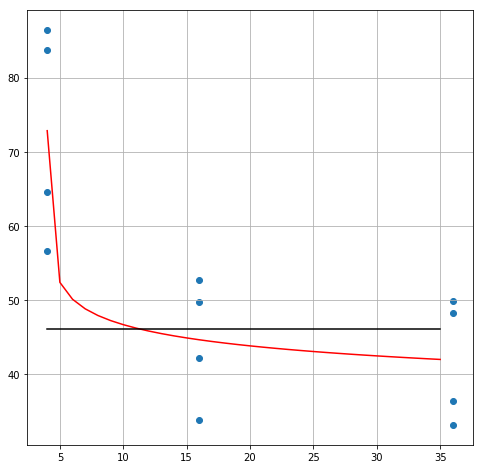

12 46.117008227077356


In [50]:
def N_Nodes(Runs,params,plot=False):
    Runs = RunLoop(Runs)
    Group = Runs.groupby('N').mean()
    Group['SD'] = Runs[['N','MSE']].groupby('N').std()
    Group['SE'] = Runs[['N','MSE']].groupby('N').sem()
    Min = Group.loc[Group['MSE']==Group['MSE'].min()]
    popt, pcov = curve_fit(Curve, Runs['N'].values, Runs['MSE'].values)
    N = np.arange(Runs['N'].min(),Runs['N'].max())
    Fit = Curve(N,*popt)
    Max = (Min['MSE']+Min['SE']).values[0]
    try:
        params['N']=N[Fit<Max].min()
    except:
        params['N']=N[-1]
        pass
    
    if plot == True:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.scatter(Runs['N'],Runs['MSE'])
        ax.plot(N,Fit,color='r')
        ax.plot(N,N*0+Max,color = 'black')
        plt.grid()
        plt.show()
    return(params)
params = N_Nodes(Runs,params)
print(params['N'],Max)

# Feature Identification

         MSE        R2  Level  Key                               Model
0  56.006588  0.650431      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
1  42.763977  0.664609      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
2  55.759391  0.651974      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
3  40.254624  0.684289      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass


In [53]:
def FactorTest(params,FullModel,Runs):
    Scores = Runs[['MSE','R2']].reset_index(drop=True)
    Scores = (Scores.iloc[0:params['K']])*0
    Scores['Level'] = len(FullModel)
    Scores['Key'] = str(Scores['Level'][0])+'_0'
    Scores['Model'] = '+'.join(FullModel)
    Results = RunReps(FullModel,params,pool)
    MSE = Results[0]
    R2 = Results[1]
    Scores['MSE']=Results[0]
    Scores['R2']=Results[1]
    ModelRuns = Results[2]
    ModelRuns = ModelRuns.to_frame()
    ModelRuns['Model: '+'+'.join(FullModel)]=ModelRuns['TempFill']
    ModelRuns=ModelRuns.drop('TempFill',axis=1)
#     print(Scores)
    
    for i in range(1,len(FullModel)):
        print('Level: ',i)
        if i == 1:
            Models = Combos(FullModel,i)
        else:
            Models = Combos(FullModel,i,factor = Best)
        Values = []
        Names = []
        for i,model in enumerate(Models):
            level = len(model)
            key = str(level)+'_'+str(i)
            Name = '+'.join(model)
            NewRow = Scores.iloc[-1].copy()
            NewRow['Model'] = 'Model: '+Name
            Results = RunReps(model,params,pool)
            MSE = Results[0]
            R2 = Results[1]
            d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
            score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
            Scores = Scores.append(score,ignore_index=True)
    #         print(Scores.loc[Scores['Key']==key])
            ModelRuns['Model: '+'+'.join(model)] = Results[2]    
        Group = Scores.groupby('Key').agg({'Model': 'first', 
            'Level': 'first','MSE': 'mean','R2': 'mean'})#.reset_index()#mean()  
        Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
        Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
        Min = Group.loc[Group['Level']==level]
        Best = Min.loc[Min['MSE'] == Min['MSE'].min(),'Model'].values
        print(Best)  
    Group = Scores.groupby('Key').agg({'Model': 'first', 
        'Level': 'first','MSE': 'mean','R2': 'mean'})#.reset_index()#mean()  
    Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
    Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
    Min = Group.loc[Group['Level']==level]

    Levels = Group.groupby('Level').min()
    Sub=Group[Group['MSE'].isin(Levels['MSE'].values)]
    print(Sub)
    Sub.sort_values('Level',inplace=True)
    Sub = Sub.loc[Sub['Level']>=1]
    Sub.reset_index(inplace=True,drop=True)
    Min = Sub.loc[Sub['MSE']==Sub['MSE'].min()]
    Parsimony = (Sub.loc[Sub['MSE']<(Min['MSE'].values+Min['SE'].values)[0]])
    Parsimony = Parsimony.loc[Parsimony['Level']==Parsimony['Level'].min()]
    print(Parsimony)
    Best = Parsimony['Model'].values
    return(Best,Scores,ModelRuns)
Best,Scores,ModelRuns = FactorTest(params,FullModel,Runs)

         MSE        R2  Level  Key                               Model
0  56.002250  0.650458      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
1  42.765566  0.664596      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
2  55.759215  0.651975      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
3  38.437589  0.698540      5  5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass
Level:  1


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


['Sedge']
Level:  2
['Sedge+VWC']
Level:  3
['PPFD_Avg+Sedge+VWC']
Level:  4


KeyboardInterrupt: 

                                  Model  Level         MSE        R2  \
Key                                                                    
1_2                               Sedge      1  119.770866  0.167086   
2_2                           Sedge+VWC      2   64.625670  0.550924   
3_0                  PPFD_Avg+Sedge+VWC      3   54.767086  0.622048   
4_1            PPFD_Avg+Sedge+VWC+Grass      4   51.770249  0.643378   
5_0  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass      5   52.452422  0.635167   

            SD        SE  
Key                       
1_2  15.496238  7.748119  
2_2   8.870236  4.435118  
3_0  11.269285  5.634643  
4_1  11.702492  5.851246  
5_0   7.429213  3.714607  
                Model  Level        MSE        R2         SD        SE
2  PPFD_Avg+Sedge+VWC      3  54.767086  0.622048  11.269285  5.634643


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


   N        MSE        R2  Model
0  4  86.460254  0.460353      0
1  4  56.663703  0.555596      0
2  4  83.724084  0.477431      0
3  4  64.594629  0.493395      0
    N        MSE        R2  Model
4  16  49.757667  0.689434      0
5  16  33.857178  0.734464      0
6  16  52.689661  0.671134      0
7  16  42.226463  0.668825      0
     N        MSE        R2  Model
8   36  49.864435  0.688768      0
9   36  36.334776  0.715032      0
10  36  48.232468  0.698954      0
11  36  33.149871  0.740011      0
          MSE        R2  Model         SD        SE
N                                                  
4   72.844246  0.496797      0  14.516919  7.258460
16  44.637092  0.690936      0   8.432130  4.216065
36  42.001118  0.710025      0   8.513944  4.256972
11


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power


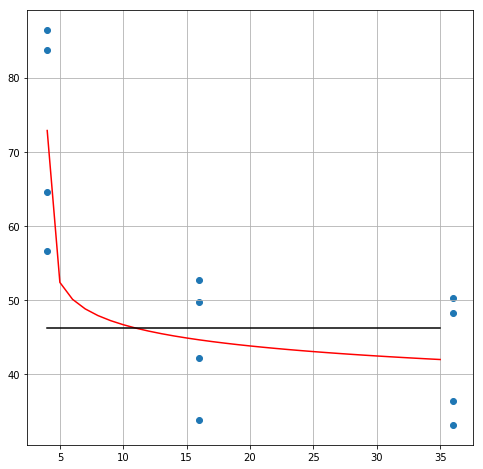

11


In [24]:
# def Curve(x,a,b,c):
#     return (a/(b+x)**c)

N = Runs['N']
NRuns = Runs*0
NRuns['N']=N
model = Best[0].split('+')

params = N_Nodes(NRuns,params)

# NRuns = RunLoop(NRuns)
# Group = Runs.groupby('N').mean()
# Group['SD'] = Runs[['N','MSE']].groupby('N').std()
# Group['SE'] = Runs[['N','MSE']].groupby('N').sem()

# print(Group)
# Min = Group.loc[Group['MSE']==Group['MSE'].min()]

# fig,ax = plt.subplots(figsize=(8,8))
# ax.scatter(Runs['N'],Runs['MSE'])
# popt, pcov = curve_fit(Curve, NRuns['N'].values, NRuns['MSE'].values)

# N = np.arange(NRuns['N'].min(),NRuns['N'].max())
# Fit = Curve(N,*popt)
# ax.plot(N,Fit,color='r')
# Max = (Min['MSE']+Min['SE']).values[0]
# ax.plot(N,N*0+Max,color = 'black')
# try:
#     params['N']=N[Fit<Max].min()
# except:
#     params['N']=N[-1]
#     pass
# print(params['N'])
# plt.grid()
# plt.show()
# print(params['N'])

In [25]:
level = 0#len(Best)
print(Best)
key = '0_'+str(params['N'])
Name = '+'.join(Best)
NewRow = Scores.iloc[-1].copy()
NewRow['Model'] = 'BestModel: '+Name
Results = RunReps(model,params,pool,Save=True)

# Results = RunReps(FullModel,params,pool)
MSE = Results[0]
# for mse in MSE:
#     Names.append(Name)
#     Values.append(mse)
# mean,std = MSE.mean(),MSE.std()
# CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
R2 = Results[1]
d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
Scores = Scores.append(score,ignore_index=True)
Scores = Scores.append(score,ignore_index=True)
ModelRuns['BestModel: '+'+'.join(model)] = Results[2] 
print(params['N'])
print(Scores)

['PPFD_Avg+Sedge+VWC']
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
11
     Key  Level         MSE                               Model        R2
0    5_0      5   58.563407  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.634473
1    5_0      5   42.521139  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.666513
2    5_0      5   57.702314  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.639847
3    5_0      5   51.022827  PPFD_Avg+AirTC_Avg+Sedge+VWC+Grass  0.599836
4    1_0      1  156.929372                            PPFD_Avg  0.020515
5    1_0      1  111.500372                            PPFD_Avg  0.125520
6    1_0      1  160.285802                            PPFD_Avg -0.000434
7    1_0      1  113.016774                            PPFD_Avg  0.113627
8    1_1      1  144.679597                           AirTC_Avg  0.096973
9    1_1      1  106.692955                           AirTC_Avg  0.163224
10   1_1      1  144.789329                           AirTC_Avg  0.096288
11   1

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [26]:
Scores.to_csv('GapFillingSummary'+FillVar+'.csv')
ModelRuns.to_csv('GapFilled'+FillVar+'.csv')

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)

267.05389308929443


Loaded model from disk


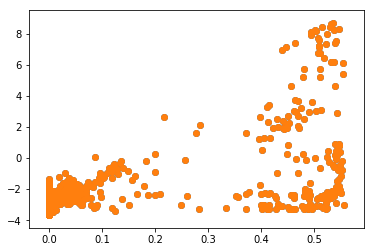

In [27]:
from keras.models import model_from_json

import ReadStandardTimeFill as RSTF
json_file = open('C:/Users/wesle/ML_GapFilling/Weights/model0.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:/Users/wesle/ML_GapFilling/Weights/0_0.h5")
print("Loaded model from disk")


# plt.figure(figsize=(10,10))
# FullModel = fco2_summary.loc[fco2_summary['Level']==0,'Model'].values[0].split('+')

for i in range(2):
    RST = RSTF.ReadStandardTimeFill('Data_Footprints_2018-06-12.csv')
    RST.Scale('fco2',model)
    y = RST.y*1.0
    X = RST.X*1.0
#     if i == 0:
#         X[:,0]=X[:,0].min()
#     if i == 1:
#         X[:,0]=X[:,0].mean()
#     if i == 2:
#         X[:,0]=X[:,0].max()
    loaded_model.compile(loss='mean_squared_error', optimizer='adam')#loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#     score = loaded_model.evaluate(X, y, verbose=1)
    rest = loaded_model.predict(X)
    rest = RST.YScaled.inverse_transform(rest.reshape(-1,1))
    X = RST.XScaled.inverse_transform(X)
#     print(score)
    plt.scatter(X[:,1],rest,label=X[:,0].mean())
# plt.legend()